# Consumption prediction
### Author : Nicolas Lacroix (https://github.com/NicolasLacroix)

Licence : [Apache License 2.0]

This notebook uses [consumption.ipynb] and [meteorology.ipynb].

[Apache License 2.0]: https://github.com/NicolasLacroix/data-representation/blob/master/LICENSE

[consumption.ipynb]: https://github.com/NicolasLacroix/data-representation/blob/master/notebooks/consumption.ipynb
[meteorology.ipynb]: https://github.com/NicolasLacroix/data-representation/blob/master/notebooks/meteorology.ipynb

In [85]:
import torch
import torch.nn as nn

## I. Data

### Importing data

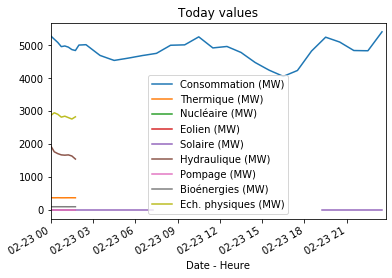

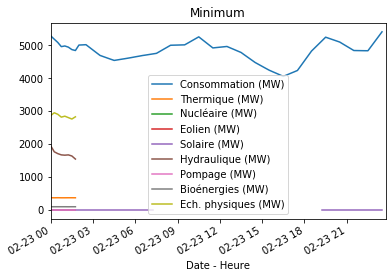

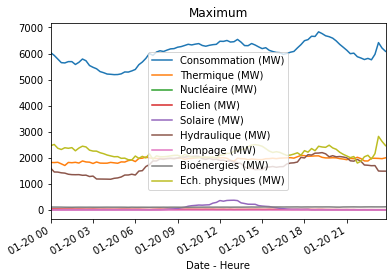

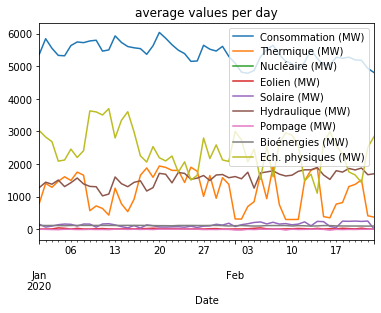

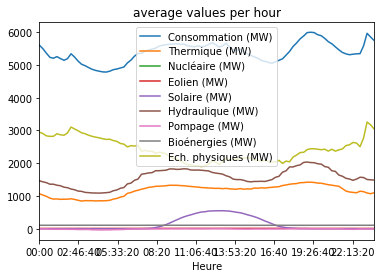

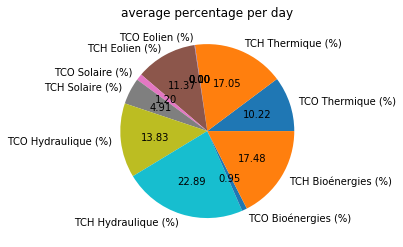

(115233, 81)
(29003, 18)


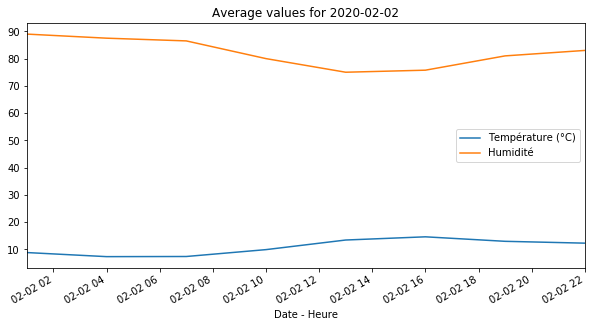

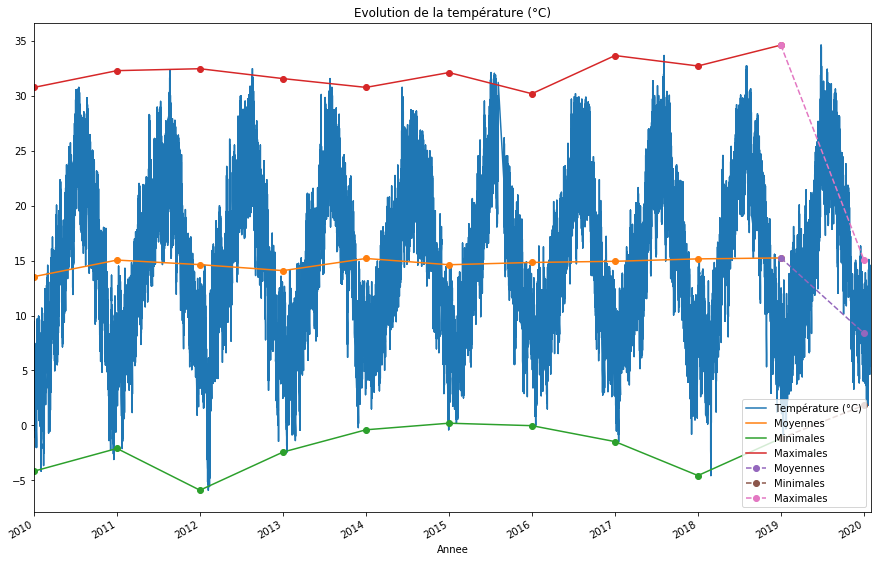

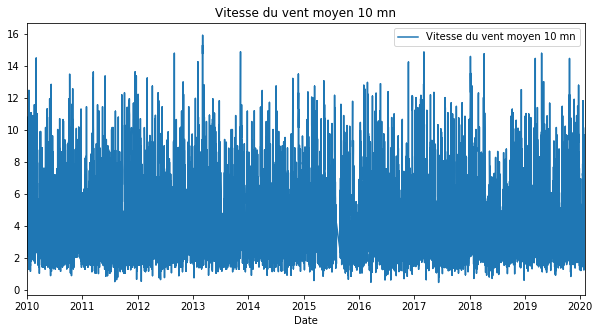

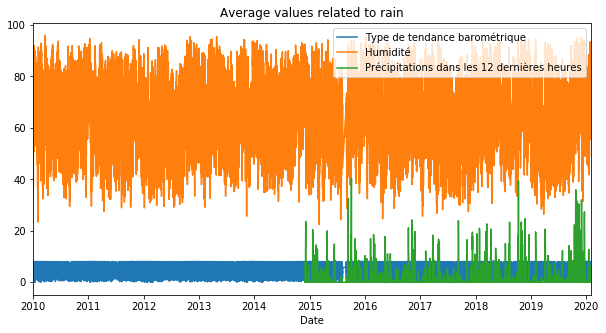

In [86]:
%run consumption.ipynb # import data
%run meteorology.ipynb # import data_meteo

### Processing data

In [87]:
print(data_meteo['Date'].dtypes == data['Date'].dtypes)
# converting data_meteo['Date']'s type to match data['Date']'s type
#data_meteo['Date'] = pd.to_datetime(data_meteo['Date'])
print(data['Date'].dtypes == data_meteo['Date'].dtypes)
# converting data['Date - Heure']

False
False


In [88]:
print(data.dtypes)
data_meteo.dtypes

Code INSEE région                             int64
Région                                       object
Nature                                       object
Date                                 datetime64[ns]
Heure                                        object
Date - Heure           datetime64[ns, Europe/Paris]
Consommation (MW)                           float64
Thermique (MW)                              float64
Nucléaire (MW)                              float64
Eolien (MW)                                 float64
Solaire (MW)                                float64
Hydraulique (MW)                            float64
Pompage (MW)                                float64
Bioénergies (MW)                            float64
Ech. physiques (MW)                         float64
TCO Thermique (%)                           float64
TCH Thermique (%)                           float64
TCO Nucléaire (%)                           float64
TCH Nucléaire (%)                           float64
TCO Eolien (

Date                                                                 object
Annee                                                                 int64
Heure                                                                object
Date - Heure                                   datetime64[ns, Europe/Paris]
Pression au niveau mer                                              float64
Variation de pression en 3 heures                                   float64
Type de tendance barométrique                                       float64
Direction du vent moyen 10 mn                                       float64
Vitesse du vent moyen 10 mn                                         float64
Point de rosée                                                      float64
Humidité                                                            float64
Temps présent                                                       float64
Pression station                                                    float64
Rafales sur 

## II. Prediction

In [89]:
TRAIN_SPLIT = 400 # size of the training dataset
NB_DAYS = 10 # number of days to be predicted

### Training dataset

In [90]:
# TODO: normalize all columns or only Consuming ?
# TODO: improve performances
# data_train = pd.concat([data, data_meteo], axis=1, join='inner')[:TRAIN_SPLIT-NB_DAYS]
data_train = pd.merge(data, data_meteo, on="Date - Heure")[:TRAIN_SPLIT-NB_DAYS]
# normalizing data
data_train_mean = data_train["Consommation (MW)"].mean()
data_train_std = data_train["Consommation (MW)"].std()
data_train["Consommation (MW)"] = (data_train["Consommation (MW)"]-data_train_mean)/data_train_std
# final training dataset
data_train

,Code INSEE région,Région,Nature,Date_x,Heure_x,Date - Heure,Consommation (MW),Thermique (MW),Nucléaire (MW),Eolien (MW),...,Temps présent,Pression station,Rafales sur une période,Periode de mesure de la rafale,Précipitations dans la dernière heure,Précipitations dans les 3 dernières heures,Précipitations dans les 6 dernières heures,Précipitations dans les 12 dernières heures,Type de tendance barométrique.1,Température (°C)
0,93,Provence-Alpes-Côte d'Azur,Données temps réel,2020-01-01,10:00:00,2020-01-01 10:00:00+01:00,-0.625810,236.0,NaN,1.0,...,0.666667,100030.0,6.425,-10.0,0.000000,0.000000,0.000000,0.000000,2.00,7.075
1,93,Provence-Alpes-Côte d'Azur,Données temps réel,2020-01-02,01:00:00,2020-01-02 01:00:00+01:00,-0.206539,558.0,NaN,1.0,...,0.666667,100020.0,5.825,-10.0,0.000000,0.000000,0.000000,0.000000,0.25,5.175
2,93,Provence-Alpes-Côte d'Azur,Données temps réel,2020-01-02,07:00:00,2020-01-02 07:00:00+01:00,-0.023108,1209.0,NaN,2.0,...,0.666667,100037.5,5.750,-10.0,0.000000,0.000000,0.000000,0.000000,4.00,4.175
3,93,Provence-Alpes-Côte d'Azur,Données temps réel,2020-01-02,13:00:00,2020-01-02 13:00:00+01:00,1.699835,1871.0,NaN,4.0,...,0.750000,100040.0,4.375,-10.0,0.000000,0.000000,0.000000,0.000000,8.00,10.175
4,93,Provence-Alpes-Côte d'Azur,Données temps réel,2020-01-02,22:00:00,2020-01-02 22:00:00+01:00,0.308815,1181.0,NaN,1.0,...,1.000000,99980.0,3.650,-10.0,0.000000,0.000000,-0.025000,-0.025000,6.25,7.875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,93,Provence-Alpes-Côte d'Azur,Données temps réel,2020-01-30,07:00:00,2020-01-30 07:00:00+01:00,0.854741,1477.0,NaN,1.0,...,0.750000,98810.0,6.800,-10.0,0.000000,0.000000,0.000000,0.000000,4.00,5.375
252,93,Provence-Alpes-Côte d'Azur,Données temps réel,2020-01-30,10:00:00,2020-01-30 10:00:00+01:00,1.025070,2068.0,NaN,1.0,...,1.000000,98917.5,6.500,-10.0,0.000000,0.000000,0.000000,0.000000,1.00,7.875
253,93,Provence-Alpes-Côte d'Azur,Données temps réel,2020-01-30,13:00:00,2020-01-30 13:00:00+01:00,0.566492,1914.0,NaN,0.0,...,0.333333,98857.5,5.700,-10.0,0.000000,0.000000,0.000000,0.000000,7.75,12.275
254,93,Provence-Alpes-Côte d'Azur,Données temps réel,2020-02-02,10:00:00,2020-02-02 10:00:00+01:00,-1.025428,308.0,NaN,3.0,...,1.500000,99210.0,8.475,-10.0,0.000000,0.000000,0.000000,0.000000,1.75,9.875


In [91]:
print(data['Date - Heure'].head())
print(data_meteo['Date - Heure'].head())

0   2020-01-01 01:45:00+01:00
1   2020-01-01 02:00:00+01:00
2   2020-01-01 02:15:00+01:00
3   2020-01-01 03:00:00+01:00
4   2020-01-01 03:30:00+01:00
Name: Date - Heure, dtype: datetime64[ns, Europe/Paris]
0   2010-01-01 01:00:00+01:00
1   2010-01-01 04:00:00+01:00
2   2010-01-01 07:00:00+01:00
3   2010-01-01 10:00:00+01:00
4   2010-01-01 13:00:00+01:00
Name: Date - Heure, dtype: datetime64[ns, Europe/Paris]


In [92]:
data_train[['Date - Heure', 'Date_x', 'Date_y', 'Heure_x', 'Heure_y', 'Consommation (MW)']]

,Date - Heure,Date_x,Date_y,Heure_x,Heure_y,Consommation (MW)
0,2020-01-01 10:00:00+01:00,2020-01-01,2020-01-01,10:00:00,10:00:00,-0.625810
1,2020-01-02 01:00:00+01:00,2020-01-02,2020-01-02,01:00:00,01:00:00,-0.206539
2,2020-01-02 07:00:00+01:00,2020-01-02,2020-01-02,07:00:00,07:00:00,-0.023108
3,2020-01-02 13:00:00+01:00,2020-01-02,2020-01-02,13:00:00,13:00:00,1.699835
4,2020-01-02 22:00:00+01:00,2020-01-02,2020-01-02,22:00:00,22:00:00,0.308815
...,...,...,...,...,...,...
251,2020-01-30 07:00:00+01:00,2020-01-30,2020-01-30,07:00:00,07:00:00,0.854741
252,2020-01-30 10:00:00+01:00,2020-01-30,2020-01-30,10:00:00,10:00:00,1.025070
253,2020-01-30 13:00:00+01:00,2020-01-30,2020-01-30,13:00:00,13:00:00,0.566492
254,2020-02-02 10:00:00+01:00,2020-02-02,2020-02-02,10:00:00,10:00:00,-1.025428


### Target dataset

In [93]:
target_data = pd.concat([data, data_meteo], axis=1, join='inner')[TRAIN_SPLIT-NB_DAYS:TRAIN_SPLIT]
# TODO : .values.astype(np.float64)
target_data

,Code INSEE région,Région,Nature,Date,Heure,Date - Heure,Consommation (MW),Thermique (MW),Nucléaire (MW),Eolien (MW),...,Temps présent,Pression station,Rafales sur une période,Periode de mesure de la rafale,Précipitations dans la dernière heure,Précipitations dans les 3 dernières heures,Précipitations dans les 6 dernières heures,Précipitations dans les 12 dernières heures,Type de tendance barométrique.1,Température (°C)
390,93,Provence-Alpes-Côte d'Azur,Données temps réel,2020-01-20,12:30:00,2020-01-20 12:30:00+01:00,6501.0,1979.0,NaN,18.0,...,1.500000,97177.5,5.800,-10.0,0.00,0.00,NaN,0.25,2.75,10.075
391,93,Provence-Alpes-Côte d'Azur,Données temps réel,2020-01-20,15:45:00,2020-01-20 15:45:00+01:00,6076.0,1982.0,NaN,19.0,...,1.500000,97052.5,8.750,-10.0,0.00,0.00,NaN,NaN,7.00,9.025
392,93,Provence-Alpes-Côte d'Azur,Données temps réel,2020-01-20,16:45:00,2020-01-20 16:45:00+01:00,6004.0,1996.0,NaN,17.0,...,20.750000,96805.0,10.650,-10.0,0.15,0.15,0.15,NaN,8.00,9.650
393,93,Provence-Alpes-Côte d'Azur,Données temps réel,2020-01-20,17:15:00,2020-01-20 17:15:00+01:00,6081.0,1985.0,NaN,17.0,...,61.250000,96110.0,18.400,-10.0,1.10,2.00,NaN,NaN,6.50,9.400
394,93,Provence-Alpes-Côte d'Azur,Données temps réel,2020-01-20,17:45:00,2020-01-20 17:45:00+01:00,6341.0,2088.0,NaN,16.0,...,61.750000,95757.5,15.850,-10.0,2.15,6.00,NaN,8.25,7.00,8.400
395,93,Provence-Alpes-Côte d'Azur,Données temps réel,2020-01-20,18:00:00,2020-01-20 18:00:00+01:00,6493.0,2082.0,NaN,18.0,...,61.666667,95615.0,14.125,-10.0,1.90,6.50,NaN,NaN,5.50,7.900
396,93,Provence-Alpes-Côte d'Azur,Données temps réel,2020-01-20,20:15:00,2020-01-20 20:15:00+01:00,6485.0,1996.0,NaN,13.0,...,35.500000,95687.5,14.400,-10.0,0.30,2.75,9.25,NaN,4.25,9.325
397,93,Provence-Alpes-Côte d'Azur,Données temps réel,2020-01-20,21:15:00,2020-01-20 21:15:00+01:00,5994.0,1974.0,NaN,10.0,...,29.000000,95892.5,13.625,-10.0,0.10,0.45,NaN,NaN,3.00,9.700
398,93,Provence-Alpes-Côte d'Azur,Données temps réel,2020-01-20,22:00:00,2020-01-20 22:00:00+01:00,5829.0,1969.0,NaN,8.0,...,0.750000,96095.0,10.650,-10.0,0.00,0.00,NaN,9.50,2.00,7.700
399,93,Provence-Alpes-Côte d'Azur,Données temps réel,2020-01-20,22:30:00,2020-01-20 22:30:00+01:00,5813.0,1875.0,NaN,8.0,...,1.500000,96270.0,12.200,-10.0,0.00,0.00,NaN,NaN,2.25,6.075


### Neural Network

In [94]:
# number of criterias 
nbIn = data_train.shape[1]
# neural network caracteristics
nbOut = 1
nbHidden = 100
# définition of the neural network
neuralNetwork = nn.Sequential(nn.Linear(nbIn,nbHidden), nn.ReLU(), nn.Linear(nbHidden,nbOut))
neuralNetwork

Sequential(
  (0): Linear(in_features=48, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=1, bias=True)
)

In [95]:
# launch criterias + optimizing options
criterion = nn.MSELoss() # MSELoss = moindres carrés
optimizer = torch.optim.SGD(neuralNetwork.parameters(), lr=0.000003) # lr = learning rate
nbEpochs = 1000 # nombre d'itérations

In [96]:
# converting data (to pytorch tensor)
input_data = torch.FloatTensor(data_train.values)
target = torch.FloatTensor(target_data.values)
#target = torch.FloatTensor(target_data.values.reshape((TRAIN_SPLIT, )))
#target = target.unsqueeze(0)

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, int64, int32, int16, int8, uint8, and bool.

### Training

In [ ]:
items = []
# launching iterations
for epoch in range(nbEpochs):
    optimizer.zero_grad() # zero_grad = ?
    output = neuralNetwork(input_data)
    print(output) # TODO: check output content (maybe prediction results)
    loss = criterion(output, target) # calcul de la fonction cout (moindres carrés)
    loss.backward() # calcul du gradient (sens = droite vers gauche)
    optimizer.step() # ? (modification des parametres du réseau de neurones)
    print(loss.item())
    items.append(loss.item())

### Results

In [ ]:
# neural network performances (loss stats)
fig, ax = plt.subplots()
x = np.arange(len(items))
ax.plot(x, items)
# TODO: improve ylabel+title
ax.set(xlabel='number of epochs', ylabel='consumption',
       title='Evolution')
plt.show()

In [ ]:
# results
# gca = get current axis
ax = plt.gca()
# dataset values
# TODO: remove label='Consommaation' ?
# TODO: specify title
data_train[['Date', 'Consommation (MW)']].plot(
    x='Date', label='Consommation', title="TODO", figsize=(15, 10), ax=ax, color="b"
)
data_target[['Date', 'Consommation (MW)']].plot(
    x='Date', label='Consommation', title="TODO", figsize=(15, 10), ax=ax, color="b"
)
# prediction results
# TODO: plot prediction results